In [1]:
import os
import io
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib.image as image
from mpl_toolkits.mplot3d import Axes3D
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

ds_grd = xr.open_dataset('../data/external/stcc_roms_grid_osu_subset1.nc')
ds_data = xr.open_dataset('../data/external/stcc_his_osu_subset_0001.nc')

In [ ]:
# Look at the data set
ds_data

In [ ]:
ds_data['zeta'][1,1,1]
# plt.plot(ds_data['ocean_time'], ds_data['w'][:,40,30,30])
plt.plot(ds_data['ocean_time'], ds_data['zeta'][:,30,30])

# Plot the Entire Surface Field

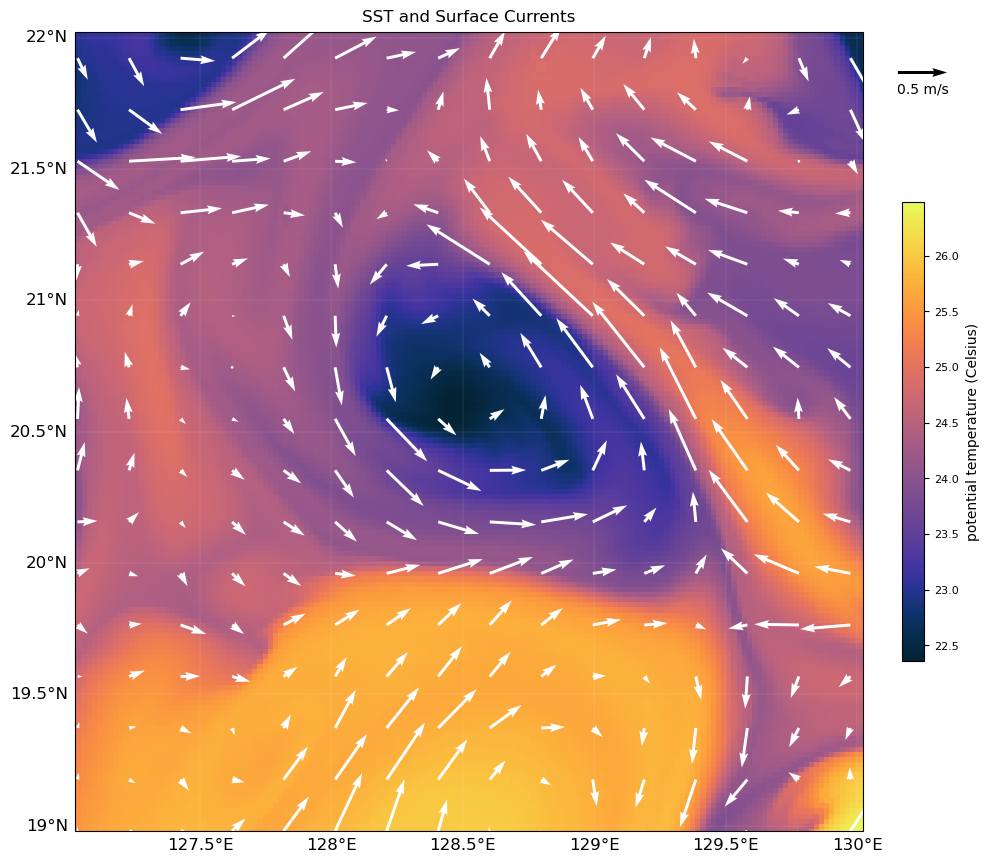

<Figure size 640x480 with 0 Axes>

In [9]:
min_lon_fld = np.min(ds_grd.lon_rho.values)
max_lon_fld = np.max(ds_grd.lon_rho.values)
min_lat_fld = np.min(ds_grd.lat_rho.values)
max_lat_fld = np.max(ds_grd.lat_rho.values)


# Figure size
size = (10, 10)

# Color from cmocean
color = cmocean.cm.thermal

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())

# and extent
ax.set_extent([min_lon_fld-0, max_lon_fld+0, min_lat_fld-0, max_lat_fld+0], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the variable at the surface at the initial recorded time interval
X = ds_grd.lon_u
Y = ds_grd.lat_u
U = ds_data.u.isel(ocean_time = 0, s_rho=49).values
V = ds_data.v.isel(ocean_time = 0, s_rho=49).values


Ux, Uy = np.gradient(U)
Vx, Vy = np.gradient(V)
Ux = Ux[0:-1,:]
Uy = Uy[0:-1,:]
Vx = Vx[:,0:-1]
Vy = Vy[:,0:-1]
V = V[:,0:-1]
U = U[0:-1,:]



cf = plt.pcolor(ds_grd.lon_rho, ds_grd.lat_rho, ds_data.temp.isel(ocean_time=0,s_rho=49).values,transform=ccrs.PlateCarree(), 
              cmap=color)#,vmin = 28, vmax = 30.5)#, add_colorbar=False)
# cf = plt.pcolor(X[0:-1,:], Y[0:-1,:], -(Ux+Vy),transform=ccrs.PlateCarree(), 
#               cmap=color, vmin = -.15, vmax = .15)#, add_colorbar=False)

# Reduce the number of quiver arrows
step = 10
X_reduced = X[::step, ::step]
Y_reduced = Y[::step, ::step]
U_reduced = U[::step, ::step]
V_reduced = V[::step, ::step]


quiver = plt.quiver(X_reduced, Y_reduced, U_reduced, V_reduced,
                    transform=ccrs.PlateCarree(), scale=8, color = 'w')      

# Vector options declaration
veclength = 0.5
maxstr = '%3.1f m/s' % veclength
qk = ax.quiverkey(quiver,1.075,0.95,veclength,maxstr,labelpos='S', 
              coordinates='axes', color = 'k').set_zorder(11)
# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, orientation="vertical")
cbar.set_label(ds_data.temp.long_name+' ('+ds_data.temp.units+')', rotation=90,
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('SST and Surface Currents',
          fontsize=12)
         

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='w', alpha=1,
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                           edgecolor='face', 
                                           facecolor='lightgray'))
ax.coastlines(linewidth=1)

plt.tight_layout()

plt.savefig('../figures/location.png', dpi=200)

plt.show()
fig.clear()
plt.close(fig)
plt.clf()

# Plot a Latitudinal Section Plot

In [ ]:
# Color from cmocean
colort = cmocean.cm.thermal
coloru = cmocean.cm.balance
ZZ = ds_grd.z_rho.sel(xi_rho = np.max(ds_grd.xi_rho))
YY = ds_grd.lat_rho.sel(xi_rho = np.max(ds_grd.xi_rho))
lat, dep = np.meshgrid(YY, ds_data.s_rho)
TTT = ds_data.temp.isel(ocean_time = 0, xi_rho = np.max(ds_grd.xi_rho))
SSS = ds_data.salt.isel(ocean_time = 0, xi_rho = np.max(ds_grd.xi_rho))

sig0 = gsw.sigma0(SSS,TTT)

#UUU= ds_data_clip.u.isel(ocean_time = 0, xi_u = np.max(ds_grd_clip.xi_u))
plt.figure(figsize=(10,6))
seclat = plt.pcolor(lat[25:-1,:], ZZ[25:-1], TTT[25:-1,:], cmap = colort, vmin = 18, vmax = 26)

contours = plt.contour(lat[25:-1,:], ZZ[25:-1], sig0[25:-1,:], colors='w')
plt.clabel(contours, inline=True, fontsize=12)
#seclat_RGB = seclat_col.reshape((rows,cols,4))

plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Latitudinal Section Plot')
#plt.gca().invert_yaxis()
plt.colorbar(seclat, label = 'Potential Temperature (C)')

plt.show()

# Select the Area of Interest (AOI), and clip the data

In [ ]:
min_lon = 129   # lower left longitude
min_lat = 19     # lower left latitude
max_lon = 130    # upper right longitude
max_lat = 20     # upper right latitude
max_dep = np.min(ZZ[25:-1])

def find_closest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# ds_grd = grid
# ds_data = ds

cval_lonmin = find_closest(ds_grd.lon_rho.values[0,:],min_lon)
cval_lonmax= find_closest(ds_grd.lon_rho.values[0,:],max_lon)
cval_latmin = find_closest(ds_grd.lat_rho.values[:,0],min_lat)
cval_latmax = find_closest(ds_grd.lat_rho.values[:,0],max_lat)

lon_idx_bnds = [cval_lonmin, cval_lonmax]
lat_idx_bnds = [cval_latmin, cval_latmax]
#miny = ds_grd.y(np.where(ds_grd.lon.values >=13))[0]

# Performing the reduction over all the dimensions except "ocean_time"
ds_grd_clip = ds_grd.sel(xi_rho=slice(*lon_idx_bnds), eta_rho=slice(*lat_idx_bnds))
ds_grd_clip = ds_grd_clip.sel(xi_u=slice(*lon_idx_bnds), eta_u=slice(*lat_idx_bnds))
ds_grd_clip = ds_grd_clip.sel(xi_v=slice(*lon_idx_bnds), eta_v=slice(*lat_idx_bnds))
ds_data_clip = ds_data.sel(xi_u=slice(*lon_idx_bnds), eta_u=slice(*lat_idx_bnds))
ds_data_clip = ds_data_clip.sel(xi_rho=slice(*lon_idx_bnds), eta_rho=slice(*lat_idx_bnds))
ds_data_clip = ds_data_clip.sel(xi_v=slice(*lon_idx_bnds), eta_v=slice(*lat_idx_bnds))

# Create the Top Surface Figure and save .png file

In [ ]:
# Figure size
size = (10, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size)#, facecolor='w', edgecolor='k')
plt.tight_layout()
# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
plt.axis('off')

# and extent
#ax.set_extent([min_lon+0, max_lon, min_lat, max_lat], ccrs.PlateCarree())
#ds_data_clip.eta_rho.isel(time=11,z=0)
# Plotting using Matplotlib 
# We plot the temp at the surface at the final recorded time interval
X = ds_grd_clip.lon_u
Y = ds_grd_clip.lat_u
U = ds_data_clip.u.isel(ocean_time = 0, s_rho=49).values
V = ds_data_clip.v.isel(ocean_time = 0, s_rho=49).values


Ux, Uy = np.gradient(U)
Vx, Vy = np.gradient(V)

Ux = Ux
Uy = Uy
Vx = Vx
Vy = Vy
V = V
U = U
# cf = plt.pcolor(ds_grd.lon_u, ds_grd.lat_u, ds_data.u.isel(ocean_time=0,s_rho=49).values,transform=ccrs.PlateCarree(), 
#               cmap=color)#,vmin = 28, vmax = 30.5)#, add_colorbar=False)
cf = plt.pcolor(X, Y, -(Ux+Vy)/2000,transform=ccrs.PlateCarree(), 
              cmap=color, vmin = -.000075, vmax = .000075)#, add_colorbar=False)

# cf = plt.pcolor(ds_grd_clip.lon_rho, ds_grd_clip.lat_rho, ds_data_clip.temp.isel(ocean_time=0,s_rho=49).values, transform=ccrs.PlateCarree(),
#               cmap=color,vmin = 22.5, vmax = 26.5)#, add_colorbar=False),

# plt.colorbar(cf)
img = plt.savefig('../figures/test1.png', dpi = 200, bbox_inches='tight', pad_inches = 0)


# Defining the quiver plot
X = ds_grd_clip.lon_u
Y = ds_grd_clip.lat_u
U = ds_data_clip.u.isel(ocean_time = 0, s_rho=49)
V = ds_data_clip.v.isel(ocean_time = 0, s_rho=49)

step = 8
X_reduced = X[::step, ::step]
Y_reduced = Y[::step, ::step]
U_reduced = U[::step, ::step]
V_reduced = V[::step, ::step]


quiver = plt.quiver(X_reduced, Y_reduced, U_reduced, V_reduced, transform=ccrs.PlateCarree(),
                    scale=5, color = 'w')#transform=ccrs.PlateCarree()      

# Add Text

plt.text(129.75, 19.06, r'$\frac{\partial u}{\partial x} \plus  \frac{\partial v}{\partial y}$', fontsize = 32)


XYimg = plt.savefig('../figures/surfqplot1.png', dpi = 300, bbox_inches='tight', pad_inches = 0)
# Vector options declaration
veclength = 0.5
maxstr = '%3.1f m/s' % veclength

plt.colorbar(cf, label = r'Horizontal Divergence ($s^{-1}$)')

XY_colorbar_img = plt.savefig('../figures/surfplot_cb.png', dpi=300, bbox_inches='tight', pad_inches = 0.5)

plt.show()




# Create the Longitudinal Section Plot and save .png file

In [ ]:
# Color from cmocean
colort = cmocean.cm.thermal
coloru = cmocean.cm.balance

ZZ1 = ds_grd_clip.z_rho.isel(eta_rho = np.min(ds_grd_clip.eta_rho))
XX = ds_grd_clip.lon_rho.sel(eta_rho = np.min(ds_grd_clip.eta_rho))
lon, dep1 = np.meshgrid(XX, ds_data_clip.s_rho)
WWW = ds_data_clip.w.isel(ocean_time = 0, eta_rho = np.min(ds_grd_clip.eta_rho))
VVV = ds_data_clip.v.isel(ocean_time = 0, eta_v = np.min(ds_grd_clip.eta_v))
TTT1 = ds_data_clip.temp.isel(ocean_time = 0, eta_rho = np.min(ds_grd_clip.eta_rho))

SSS1 = ds_data_clip.salt.isel(ocean_time = 0, eta_rho = np.min(ds_grd_clip.eta_rho))

sig0 = gsw.sigma0(SSS1,TTT1)
N2, pmid = gsw.Nsquared(SSS1,TTT1,ZZ1, lat = 20, axis=0)

plt.figure(figsize=(10,6))
plt.axis('off')

seclon = plt.pcolor(lon[25:-1,:], ZZ1[25:-1], WWW[27:-1,0:-1], cmap = coloru, vmin = -.002, vmax = .002)

levels1 = np.linspace(22.8, 23.4, 4)
levels2 = np.linspace(23.6, 24.8, 4)
contours1 = plt.contour(lon[25:-1,:], ZZ1[25:-1], sig0[25:-1,:], levels1, colors='k')
contours2 = plt.contour(lon[25:-1,:], ZZ1[25:-1], sig0[25:-1,:], levels2, colors='k')
# manual_loc1 = [(129.22, -50), (129.35,-75), (129.4, -100), (129.65, -245), (129.75, -75), (129.78, -40), (129.9, -30), (129.92, -60)]
manual_loc = [(129.22, -170), (129.65, -180), (129.22, -215), (129.65, -245)]
ca = plt.clabel(contours1, inline=True, inline_spacing = 5, fontsize=12)# 
cb = plt.clabel(contours2, inline=True, inline_spacing = 5, manual=manual_loc, fontsize=12)#, 
#[txt.set_bbox(dict(boxstyle='square,pad=0',fc='red')) for txt in cb]
#plt.colorbar(seclon)
# plt.xlabel('Latitude')
# plt.ylabel('Depth (m)')

plt.text(129.93, -30, 'w', fontsize = 20)

XZimg = plt.savefig('../figures/seclon.png', dpi = 300, bbox_inches='tight', pad_inches = 0)



# Create the Latitudinal Section Plot and save .png file

In [ ]:
# Color from cmocean
colort = cmocean.cm.thermal
coloru = cmocean.cm.balance
ZZ = ds_grd_clip.z_rho.sel(xi_rho = np.max(ds_grd_clip.xi_rho))
YY = ds_grd_clip.lat_rho.sel(xi_rho = np.max(ds_grd_clip.xi_rho))
lat, dep = np.meshgrid(YY, ds_data_clip.s_rho)
TTT = ds_data_clip.temp.isel(ocean_time = 0, xi_rho = np.max(ds_grd_clip.xi_rho))
UUU = ds_data_clip.u.isel(ocean_time = 0, xi_u = np.max(ds_grd_clip.xi_u))
WWW = ds_data_clip.w.isel(ocean_time = 0, xi_rho = np.max(ds_grd_clip.xi_rho))
SSS = ds_data_clip.salt.isel(ocean_time = 0, xi_rho = np.max(ds_grd_clip.xi_rho))

sig0 = gsw.sigma0(SSS,TTT)
N2, pmid = gsw.Nsquared(SSS,TTT,ZZ, lat = 20, axis=0)

plt.figure(figsize=(10,6))
plt.axis('off')
seclat = plt.pcolor(lat[25:-1,:], ZZ[25:-1], WWW[27:-1,0:-1], cmap = coloru, vmin = -.002, vmax = .002)


levels1 = np.linspace(22.8, 23.4, 4)
levels2 = np.linspace(23.6, 24.8, 4)
contours1 = plt.contour(lat[25:-1,:], ZZ[25:-1], sig0[25:-1,:], levels1, colors='k')
contours2 = plt.contour(lat[25:-1,:], ZZ[25:-1], sig0[25:-1,:], levels2, colors='k')
manual_loc1 = [(19.1, -30), (19.20, -55), (19.22, -100), (19.55, -120), (19.75, -50)]
manual_loc2 = [(19.28, -120), (19.65, -150), (19.28, -180), (19.65, -245)]
plt.clabel(contours1, inline=True, inline_spacing = 5, manual = manual_loc1, fontsize=12)
plt.clabel(contours2, inline=True, inline_spacing = 5, manual = manual_loc2, fontsize=12)

plt.text(19.07, -30, 'w', fontsize = 20)


YZimg = plt.savefig('../figures/seclat.png', dpi=300, bbox_inches='tight', pad_inches = 0)

plt.colorbar(seclat, label = 'Vertical Velocity W (m/s)')

YZ_colorbar_img = plt.savefig('../figures/seclat_cb.png', dpi=300, bbox_inches='tight', pad_inches = 0.5)

plt.show()


# Build the waterfall plot

In [ ]:

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection = '3d')

Ctest = image.imread('../figures/test1.png')
Cxy = image.imread('../figures/surfqplot1.png')
Cxz = image.imread('../figures/seclon.png')
Cyz = image.imread('../figures/seclat.png')

yp, xp, __ = Cxy.shape
zp, xp1, __ = Cxz.shape
zp, yp1, __ = Cyz.shape

x = np.linspace(min_lon, max_lon, xp)
y = np.linspace(min_lat, max_lat, yp)
Xy, Yx = np.meshgrid(x, y)
Z1 = np.zeros_like(Yx)

xz = np.linspace(min_lon, max_lon, xp1)
yz = np.linspace(min_lat, max_lat, yp1)
z = np.linspace(max_dep,0,zp)
Xz, Zx = np.meshgrid(xz, z)
Yz, Zy = np.meshgrid(yz, z)


# ax = fig.gca(projection='3d')
#ax.dist=6.2
ax.view_init(elev=38, azim=-45)

ax.plot_surface(Xy, Yx, Z1, facecolors=np.flipud(Cxy),
                rstride=2, cstride=2,
                antialiased=True, shade=False)

ax.plot_surface(Xz, np.min(Yz)*np.ones_like(Xz), Zx, facecolors=np.flipud(Cxz),
                rstride=2, cstride=2,
                antialiased=True, shade=False)

ax.plot_surface(np.max(Xz)*np.ones_like(Yz), Yz, Zy, facecolors=np.flipud(Cyz),
                rstride=2, cstride=2,
                antialiased=True, shade=False)

fig.colorbar(seclat, label = 'Temperature (C)')
#plt.rcParams['text.usetex'] = True
ax.set_xlim([min_lon,max_lon])
ax.set_ylim([min_lat,max_lat])
ax.set_zlim([np.round(max_dep,-2),0])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (m)')
ax.set_title('Surface Divergence and W Waterfall', fontsize=16)

WFimg = plt.savefig('../figures/Waterfall_div_w.png', dpi = 300)

plt.show()